# CLIP + SAM

In [2]:
print("kernal-live")

kernal-live


In [1]:
import cv2
import tqdm
from segment_anything import build_sam, SamAutomaticMaskGenerator,sam_model_registry
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from KeyBertTest import extract_only_keywords

d:\clip\SAM-CLIP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check gpu
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [4]:
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH=r"D:\clip\SAM-CLIP\sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
# Download the model weights and load
mask_generator = SamAutomaticMaskGenerator(sam)

In [3]:
# image_path = "assets/areoplane_prompt.jpg"
image_path = "assets/example-image.jpg"

In [4]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Generate masks from SAM

In [8]:
# masks = mask_generator.generate(image)

### Code for Save/Load the mask to avoid Re-running

In [9]:
# import pickle
# with open('masks_aero.pkl', 'wb') as f:
#     pickle.dump(masks, f)
    

In [5]:
import pickle
with open('masks.pkl', 'rb') as f:
    masks = pickle.load(f)

In [6]:
masks

[{'segmentation': array([[False, False,  True, ...,  True, False, False],
         [False, False,  True, ...,  True, False, False],
         [False, False,  True, ...,  True, False, False],
         ...,
         [False, False,  True, ...,  True, False, False],
         [False, False,  True, ...,  True, False, False],
         [False, False,  True, ...,  True, False, False]]),
  'area': 280649,
  'bbox': [1, 0, 637, 652],
  'predicted_iou': 1.0420689582824707,
  'point_coords': [[90.0, 234.671875]],
  'stability_score': 0.9894211888313293,
  'crop_box': [0, 0, 640, 653]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 15615,
  'bbox': [171, 213, 163

# Plot all masks

In [7]:
def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))

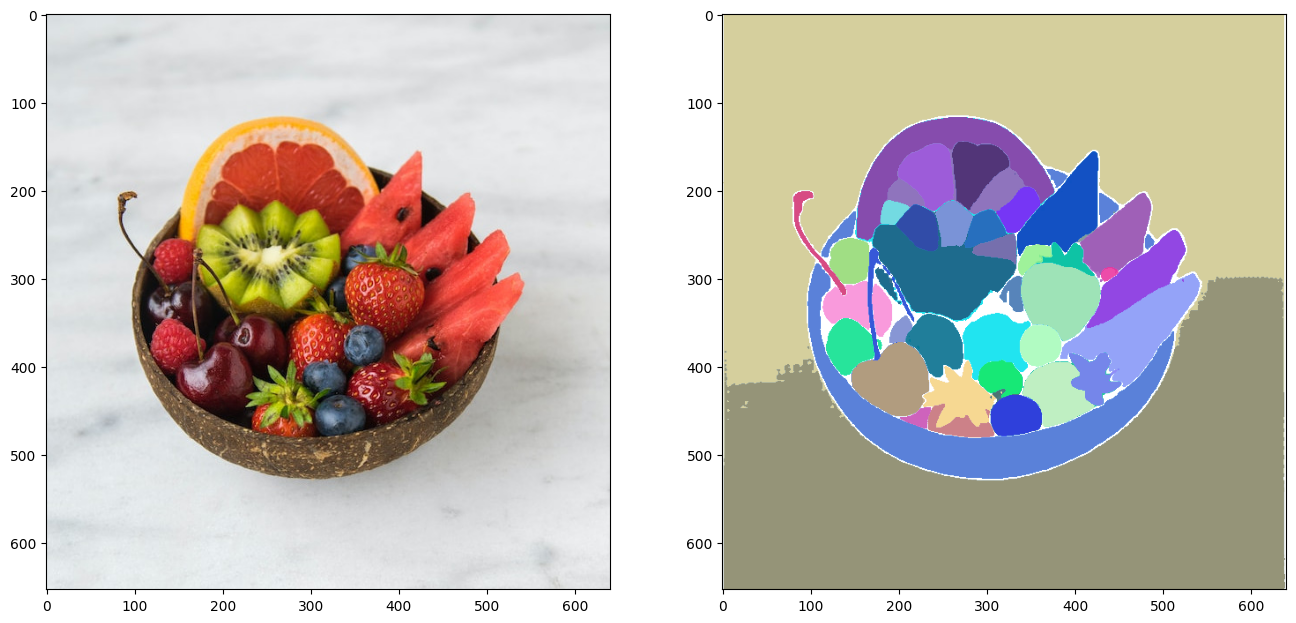

In [8]:
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image)
show_output(masks, axes[1])

In [9]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [10]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [12]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

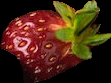

In [14]:
display(cropped_boxes[5])

In [15]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [16]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [19]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

In [21]:
prompt="A picture of areoplane in a thunderstrom."
# prompt="Strawberry and kiwi"

key_prompt=extract_only_keywords(prompt)
print(key_prompt)

['areoplane', 'thunderstrom', 'picture']


0.179688
[40]


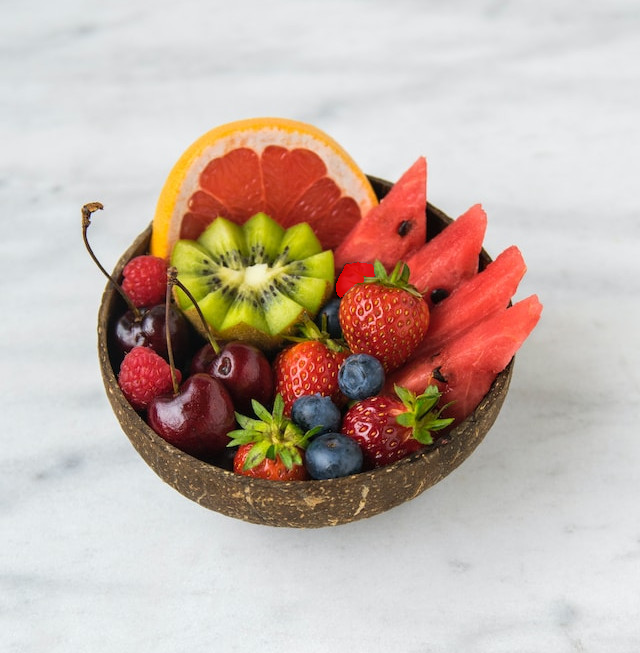

0.128174
[35]


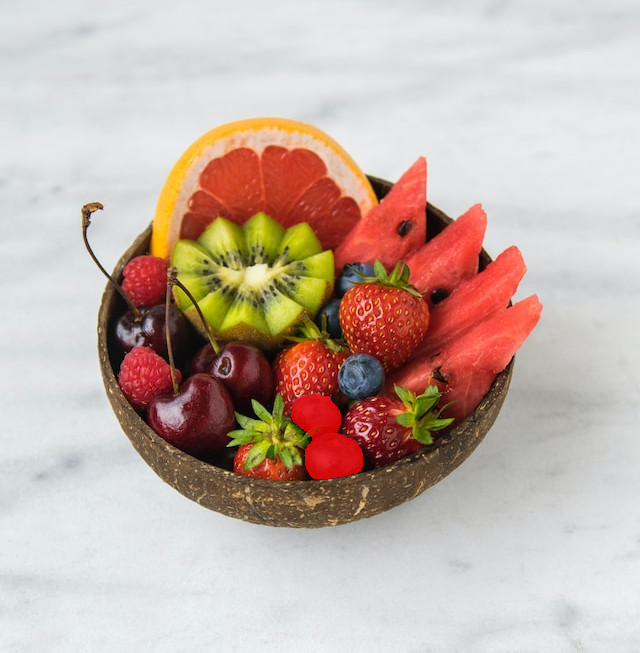

[]


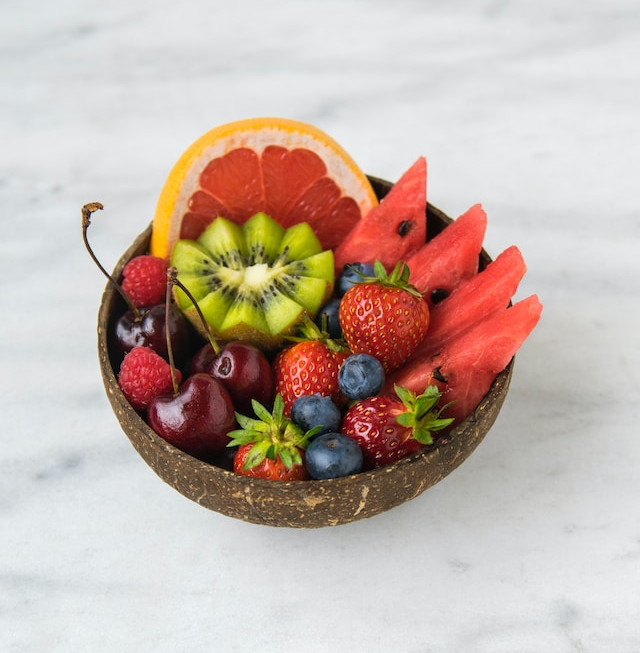

In [22]:
def visulize(cropped_boxes,text,original_image_path):
    scores = retriev(cropped_boxes, text)
    array = sorted(scores.cpu().numpy(),reverse=True)
    # Print the values as normal float values
    for value in array:
        if(value) >0.1:
            print('{:.6f}'.format(value))
    indices = get_indices_of_values_above_threshold(scores, 0.1)
    print(indices)

    segmentation_masks = []

    for seg_idx in indices:
        segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
        segmentation_masks.append(segmentation_mask_image)

    original_image = Image.open(original_image_path)
    overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
    overlay_color = (255, 0, 0, 200)

    draw = ImageDraw.Draw(overlay_image)
    for segmentation_mask_image in segmentation_masks:
        draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

    result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
    display(result_image)
for i in key_prompt:
    visulize(cropped_boxes,i,image_path)

In [23]:
# sam.to(torch.device("cpu"))
# del sam
# torch.cuda.empty_cache()